In [239]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import selfies as sf
from rdkit import Chem, RDLogger
from rdkit.Chem import Draw, QED, Descriptors
import matplotlib.pyplot as plt

RDLogger.DisableLog('rdApp.*')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [240]:

# ==========================================
# 1. 資料讀取與拆分 (Train / Test Split)
# ==========================================

def load_moses_data(filepath='dataset_v1.csv'):
    print(f"讀取與拆分 {filepath} ...")
    df = pd.read_csv(filepath)
    
    return (
        df[df['SPLIT'] == 'train']['SMILES'].values,
        df[df['SPLIT'] == 'test']['SMILES'].values
    )

train_smiles, test_smiles = load_moses_data()
max_samples = 80000
if max_samples:
        train_smiles = train_smiles[:max_samples]
        test_smiles = test_smiles[:int(max_samples * 0.2)] # Test 取 Train 的 20% 量
        
print(f"Train: {len(train_smiles)}, Test: {len(test_smiles)}")



# ==========================================
# 2. SELFIES 轉換與詞彙表 (優化版)
# ==========================================

MAX_SEQ_LEN = 64

def safe_encode(smi):
    try:
        s = sf.encoder(smi)
        if s:
            if sf.len_selfies(s) < MAX_SEQ_LEN:
                return s
    except:
        pass
    return None

print("\n正在轉換資料 (SMILES -> SELFIES)...")
train_selfies = [s for s in (safe_encode(x) for x in train_smiles) if s is not None]
test_selfies  = [s for s in (safe_encode(x) for x in test_smiles)  if s is not None]

print("建立詞彙表...")
# selfies 內建函數，直接吃 List 吐出 Set，比手寫迴圈快
vocab_set = sf.get_alphabet_from_selfies(train_selfies)
vocab = sorted(list(vocab_set)) # 先排序其他化學符號
# 修正：強制讓 [nop] 成為 Index 0
if "[nop]" in vocab:
    vocab.remove("[nop]") # 如果裡面已經有了，先移除
    print("theres nop")
vocab.insert(0, "[nop]")  # 強制插入到第一個位置

char_to_int = {c: i for i, c in enumerate(vocab)}
int_to_char = {i: c for i, c in enumerate(vocab)}

print(f"Vocab Size: {len(vocab)}")

讀取與拆分 dataset_v1.csv ...
Train: 80000, Test: 16000

正在轉換資料 (SMILES -> SELFIES)...
建立詞彙表...
Vocab Size: 27


In [241]:

# ==========================================
# 3. Dataset 與 DataLoader
# ==========================================

class MosesDataset(Dataset):
    def __init__(self, selfies_list, char_to_int, max_len):
        self.data = []
        for s in selfies_list:
            tokens = list(sf.split_selfies(s))
            # 加上 [GO] (Start Token) 和 [EOS] (End Token) 是更好的做法，
            # 這裡為了配合你的架構，我們先簡化，假設 padding 為 0
            encoded = [char_to_int.get(t, 0) for t in tokens]
            
            # Padding / Truncating
            if len(encoded) < max_len:
                encoded += [0] * (max_len - len(encoded))
            else:
                encoded = encoded[:max_len]
            self.data.append(encoded)
            
        self.data = torch.tensor(self.data, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

train_dataset = MosesDataset(train_selfies, char_to_int, MAX_SEQ_LEN)
test_dataset = MosesDataset(test_selfies, char_to_int, MAX_SEQ_LEN)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [242]:

# ==========================================
# 4. VAE 模型 (維持不變)
# ==========================================

class DrugVAE(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, latent_dim, max_len):
        super(DrugVAE, self).__init__()
        self.max_len = max_len
        
        # Encoder
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.encoder_lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, num_layers=2)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder_lstm = nn.LSTM(latent_dim, hidden_dim, batch_first=True, num_layers=2)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        embedded = self.embedding(x)
        _, (h_n, _) = self.encoder_lstm(embedded)
        h_last = h_n[-1] 
        mu = self.fc_mu(h_last)
        logvar = self.fc_logvar(h_last)
        z = self.reparameterize(mu, logvar)
        
        z_repeated = z.unsqueeze(1).repeat(1, self.max_len, 1)
        decoder_output, _ = self.decoder_lstm(z_repeated)
        recon_x = self.fc_out(decoder_output)
        return recon_x, mu, logvar

model = DrugVAE(len(vocab), 128, 256, 128, MAX_SEQ_LEN).to(device)

# ==========================================
# 5. 訓練迴圈 (含 Validation Step)
# ==========================================

def loss_function(recon_x, x, mu, logvar, kl_weight):
    B, L, V = recon_x.shape
    recon_loss = F.cross_entropy(recon_x.view(-1, V), x.view(-1), reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss * kl_weight

print("\n開始訓練...")

BATCH_SIZE = 256
EPOCHS = 24
MAX_KL_WEIGHT = 0.05
KL_WARMUP_EPOCHS = 2
KL_ANNEAL_CYCLE = 5 

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


train_losses = []
test_losses = []
kl_weights = []

optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
    if epoch < KL_WARMUP_EPOCHS:
        current_kl_weight = 0.0
    else:
        # 計算斜率：讓它在 KL_ANNEAL_CYCLE 結束時達到 MAX_KL_WEIGHT
        progress = (epoch - KL_WARMUP_EPOCHS) / (KL_ANNEAL_CYCLE - KL_WARMUP_EPOCHS)
        progress = min(1.0, progress) # 上限為 1.0
        current_kl_weight = progress * MAX_KL_WEIGHT
    
    kl_weights.append(current_kl_weight)
    
    # --- Training ---
    model.train()
    batch_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        
        loss = loss_function(recon_batch, data, mu, logvar, current_kl_weight)
        
        loss.backward()
        
        optimizer.step()
        batch_loss += loss.item()
    
    avg_train_loss = batch_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    
    # --- Validation ---
    model.eval()
    val_batch_loss = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar, current_kl_weight)
            val_batch_loss += loss.item()
            
    avg_test_loss = val_batch_loss / len(test_loader.dataset)
    test_losses.append(avg_test_loss)
    
    print(f'Epoch: {epoch+1}/{EPOCHS} | KL: {current_kl_weight:.5f} | Train Loss: {avg_train_loss:.2f} | Test Loss: {avg_test_loss:.2f}')



開始訓練...
Epoch: 1/24 | KL: 0.00000 | Train Loss: 90.31 | Test Loss: 80.02
Epoch: 2/24 | KL: 0.00000 | Train Loss: 79.44 | Test Loss: 80.28
Epoch: 3/24 | KL: 0.00000 | Train Loss: 79.07 | Test Loss: 79.35
Epoch: 4/24 | KL: 0.01667 | Train Loss: 76.51 | Test Loss: 73.02
Epoch: 5/24 | KL: 0.03333 | Train Loss: 71.08 | Test Loss: 70.55
Epoch: 6/24 | KL: 0.05000 | Train Loss: 70.80 | Test Loss: 70.97
Epoch: 7/24 | KL: 0.05000 | Train Loss: 69.60 | Test Loss: 70.36
Epoch: 8/24 | KL: 0.05000 | Train Loss: 69.21 | Test Loss: 69.51
Epoch: 9/24 | KL: 0.05000 | Train Loss: 68.56 | Test Loss: 68.32
Epoch: 10/24 | KL: 0.05000 | Train Loss: 68.89 | Test Loss: 68.26
Epoch: 11/24 | KL: 0.05000 | Train Loss: 69.08 | Test Loss: 68.52
Epoch: 12/24 | KL: 0.05000 | Train Loss: 69.01 | Test Loss: 67.98
Epoch: 13/24 | KL: 0.05000 | Train Loss: 68.45 | Test Loss: 69.07
Epoch: 14/24 | KL: 0.05000 | Train Loss: 68.73 | Test Loss: 67.96
Epoch: 15/24 | KL: 0.05000 | Train Loss: 68.65 | Test Loss: 68.84
Epoch: 16/

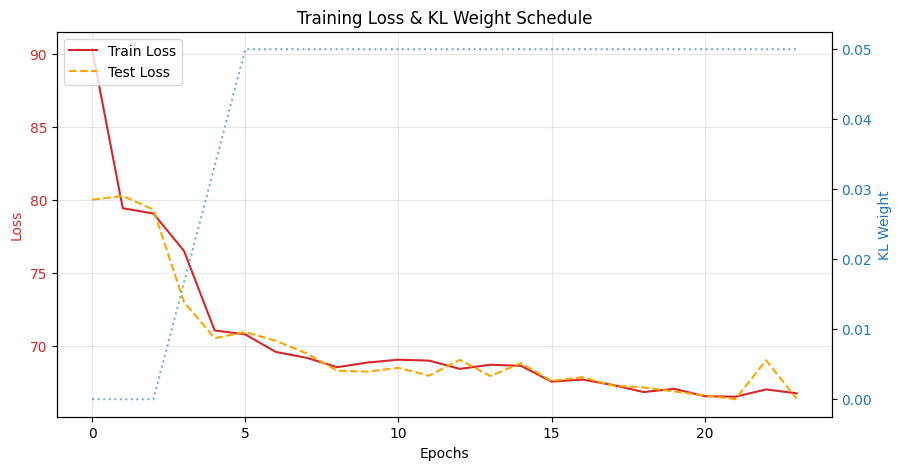

In [243]:
# ==========================================
# 功能 1: 繪製 Loss Curve
# ==========================================
def plot_training_history():
    fig, ax1 = plt.subplots(figsize=(10, 5))

    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(train_losses, label='Train Loss', color=color, linestyle='-')
    ax1.plot(test_losses, label='Test Loss', color='orange', linestyle='--')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)

    # 畫出 KL Weight 的變化 (雙 Y 軸)
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('KL Weight', color=color)  
    ax2.plot(kl_weights, label='KL Weight', color=color, linestyle=':', alpha=0.6)
    ax2.tick_params(axis='y', labelcolor=color)
    
    plt.title('Training Loss & KL Weight Schedule')
    plt.show()

plot_training_history()


正在生成 500 個候選分子並進行 QED 篩選...
有效分子數量: 70 / 500


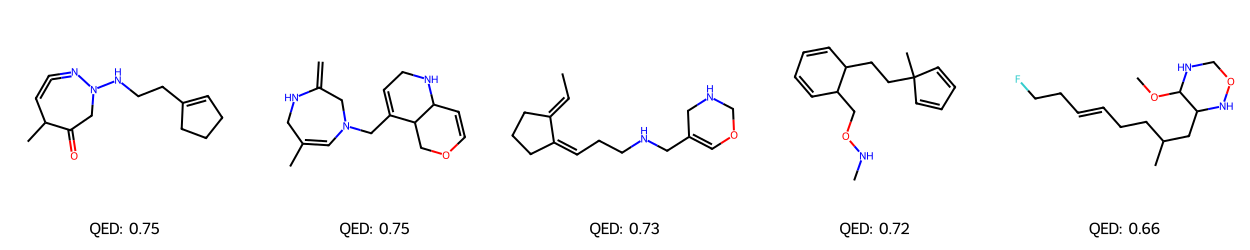

In [265]:
def generate_top_qed_molecules(n_top=5, n_candidates=100):
    """
    生成 n_candidates 個分子，計算 QED 分數，
    最後回傳分數最高的 n_top 個分子圖片。
    """
    model.eval()
    print(f"\n正在生成 {n_candidates} 個候選分子並進行 QED 篩選...")
    
    candidates = []
    
    with torch.no_grad():
        # 批次生成以加快速度 (一次生成全部)
        z = torch.randn(n_candidates, 128).to(device)
        z_repeated = z.unsqueeze(1).repeat(1, MAX_SEQ_LEN, 1)
        
        decoder_output, _ = model.decoder_lstm(z_repeated)
        recon_x = model.fc_out(decoder_output)
        
        # 使用溫度採樣 (Temperature Sampling) 增加多樣性
        temperature = 1.0
        logits = recon_x / temperature
        probs = F.softmax(logits, dim=-1)
        
        # 針對每個時間步進行採樣
        predictions = torch.zeros(n_candidates, MAX_SEQ_LEN).to(device)
        for i in range(MAX_SEQ_LEN):
            predictions[:, i] = torch.multinomial(probs[:, i, :], 1).squeeze()
            
        predictions = predictions.cpu().numpy()

    # 解碼與評分
    valid_count = 0
    for i in range(n_candidates):
        selfies_str = ""
        for idx in predictions[i]:
            token = int_to_char.get(int(idx), "[nop]")
            if token == "[nop]": break
            selfies_str += token
        
        try:
            smiles = sf.decoder(selfies_str)
            mol = Chem.MolFromSmiles(smiles)
            
            if mol:
                if mol.GetNumHeavyAtoms() < 12:
                    continue
                
                # 取得分子中所有環的資訊
                ri = mol.GetRingInfo()
                atom_rings = ri.AtomRings()
                
                # (藥物通常是 5, 6, 7 元環)
                has_large_ring = False
                has_stable_ring = False
                
                for ring in atom_rings:
                    ring_size = len(ring)
                    if ring_size > 7:
                        has_large_ring = True
                        break
                    if ring_size >= 5: # 只要有一個環 >= 5，就標記為合格
                        has_stable_ring = True
                if has_large_ring: continue # 丟棄這個分子
                if not has_stable_ring: continue # 淘汰全由 3, 4 元環組成的分子
                
                score = QED.qed(mol)
                candidates.append((mol, score, smiles))
                valid_count += 1
        except:
            pass
            
    print(f"有效分子數量: {valid_count} / {n_candidates}")
    
    # 根據 QED 分數由高到低排序
    candidates.sort(key=lambda x: x[1], reverse=True)
    
    # 取前 n_top 個
    top_mols = []
    legends = []
    
    for mol, score, smi in candidates[:n_top]:
        top_mols.append(mol)
        legends.append(f"QED: {score:.2f}")
        
    if top_mols:
        return Draw.MolsToGridImage(top_mols, molsPerRow=5, subImgSize=(250, 250), legends=legends)
    else:
        print("未能生成符合條件的分子。")
        return None

# 執行篩選
img = generate_top_qed_molecules(n_top=5, n_candidates=500) # 嘗試生成 300 個挑最好的 5 個
img